# ML Exercise: Anomaly detection in high energy physics

<img src="images/front.png" alt="AD" width="300" img align="right"/>

In this notebook we will demonstrate how to design a tiny autoencoder (AE) that we will use for anomaly detection in particle physics. More specifically, we will demonstrate how we can use autoencoders to select potentially New Physics enhanced proton collision events in a more unbiased way!

We will train the autoencoder to learn to compress and decompress data, assuming that for highly anomalous events, the AE will fail.

## Dataset

As a dataset, we will use the CMS Open data that you have been made familiar with already. Our dataset will be represented as an array of missing transverse energy (MET), up to 4 electrons, up to 4 muons and 10 jets each described by pT, η, φ and particle ID (just from knowing whether it is a muon/electron/jet)--recid 63168 --protocol xrootd. The particles are ordered by pT. If fewer objects are present, the event is zero padded.

We will train on a QCD MC dataset (we could also train directly on data), and evaluate the AE performance on a New Physics simulated sample: A Bulk graviton decaying to two vector bosons: G(M=2 TeV) → WW

We'll train using background data only and test using both background and the Graviton sample. Let's fetch them! The background data are available [here](https://opendata.cern.ch/record/63168) (recid = 63168) and the signal data [here](https://opendata.cern.ch/record/33703) (recid = 33703). The signal consists of 1,37M events and the background 19,279M events. We will use roughly 500K for each process.

We will use the docker client to print all the file names. You can then use this list to concatenate data from all the files.

In [ ]:
# # Install necessary ML packages unless you did so from the terminal already! Remember to restart the kernel after!!
# %pip install qkeras==0.9.0 tensorflow==2.11.1 hls4ml h5py mplhep cernopendata-client pydot graphviz
# %pip install --upgrade matplotlib

In [1]:
import subprocess
import numpy as np

command = ["cernopendata-client", "get-file-locations", "--recid", "63168", "--protocol", "xrootd"]
result = subprocess.run(command, capture_output=True, text=True)
filenames = result.stdout.splitlines()
filenames_bkg = np.array(filenames)

command = ["cernopendata-client", "get-file-locations", "--recid", "33703", "--protocol", "xrootd"]
result = subprocess.run(command, capture_output=True, text=True)
filenames = result.stdout.splitlines()
filenames_sig = np.array(filenames)

# Print the NumPy array
print(filenames_bkg)
print(filenames_sig)

['root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asy

In [2]:
import uproot
import matplotlib.pylab as plt
import awkward as ak
import numpy as np
from glob import glob

treename = "Events"
branch_dict = {
                "Muon": ["pt", "eta", "phi"],
                "Electron": ["pt", "eta", "phi"],
                "FatJet": ["pt", "eta", "phi"],
                # "MET": ["pt", "phi"]
            }

# make list of branches to read from the dictionary above
branch_names = []
for obj, var in branch_dict.items(): 
    branch_names += [obj + "_" + v for v in var]

infiles_sig = filenames_sig[1:2] # Lets use all the signal files

data_sig = uproot.concatenate({fname:"Events" for fname in infiles_sig}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")

# infiles_bkg = ["root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/397D1673-167A-CF46-9E79-D7069D9AC359.root"]
infiles_bkg = filenames_bkg[4:5] #Let's use only 4 of the background files, one of the first files seems to not be accessible with xrootd so I take entry 4-8
data_bkg = uproot.concatenate({fname:"Events" for fname in infiles_bkg}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")


# # Here is an example of how you can open a single file rith awkward and regex for the branch expression :

# file_bkg = uproot.open(infiles_bkg[0])
# data_bkg = file_bkg["Events"].arrays(
#     filter_name = "/(Muon|Electron|FatJet|MET)_(pt|eta|phi|sumEt)/", 
#     how = "zip"
# )

Now we have each object grouped in a respective field, and the variables are accesible at the next level (this is a result of using how="zip" when loading)

In [3]:
data_sig.fields

['Muon', 'Electron', 'FatJet']

In [4]:
data_sig.FatJet.fields

['pt', 'eta', 'phi']

In [5]:
print(f"Training on N signal samples: {len(data_sig)}")
print(f"Training on N backgr samples: {len(data_bkg)}")

Training on N signal samples: 1000
Training on N backgr samples: 2000


Alright, let's look at the data and prepare our 1-D array:

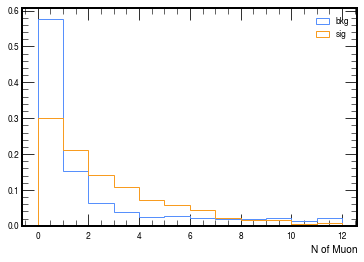

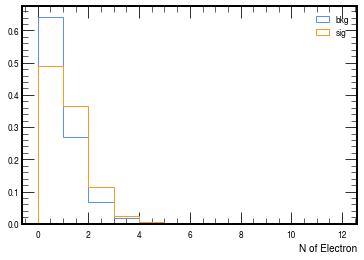

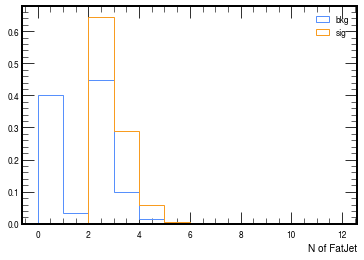

In [6]:
import mplhep
mplhep.style.use('CMS')

for obj in [ 'Muon', 'Electron', 'FatJet']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj])
        plt.hist(num, label = label, bins = range(13), density = True, 
                 #log = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()
#     plt.grid()

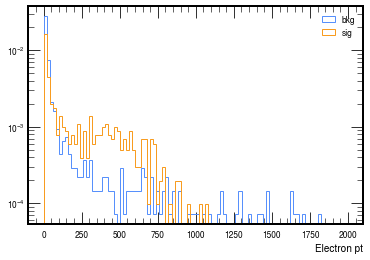

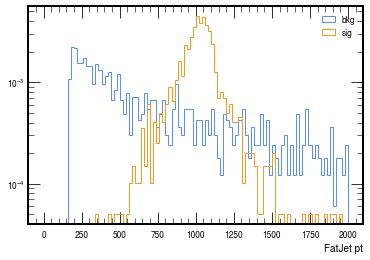

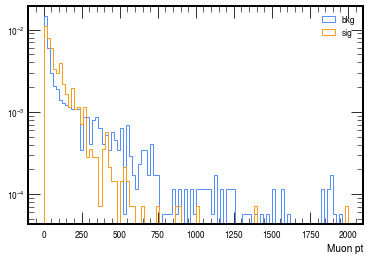

In [7]:
 for obj in [ 'Electron', 'FatJet', 'Muon']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # notice the [:,:1] below -> we slice the array and select no more than the first entry per event
        # ak.ravel makes the array flat such that we can fill a histogram
        plt.hist(ak.ravel(data[obj].pt[:,:1]), label = label, bins = np.linspace(1, 2000, 101), density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} pt")
    plt.legend()
#     plt.grid()

# Convert data to regular array for ML usage

Now we need to convert this to something regular that an ML algorithm can use! We will use dedicated functions to ease this conversion from jagged to regular format

In [8]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatData(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above
    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    for obj in objects: 
        print(obj)
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return np.concatenate(dataList, axis = 0).T, varList

In [9]:
 objects = [
    # {"name" : "MET", "key" : "MET", "fields" : ["pt", "phi"], "n_obj" : 1 },
    {"name" : "FatJet", "key" : "FatJet", "fields" : ["pt", "eta", "phi"], "n_obj" : 6},
    {"name" : "Electron", "key" : "Electron", "fields" : ["pt", "eta", "phi"], "n_obj" : 4},
    {"name" : "Muon", "key" : "Muon", "fields" : ["pt", "eta", "phi"], "n_obj" : 4}
]
    
x_sig, var_names = formatData(data_sig, objects, verbosity = 99) 
x_bkg, var_names = formatData(data_bkg, objects, verbosity = 0) 

{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 6}
{'name': 'Electron', 'key': 'Electron', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
{'name': 'Muon', 'key': 'Muon', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
The input variables are the following:
['FatJet_0_pt', 'FatJet_0_eta', 'FatJet_0_phi', 'FatJet_1_pt', 'FatJet_1_eta', 'FatJet_1_phi', 'FatJet_2_pt', 'FatJet_2_eta', 'FatJet_2_phi', 'FatJet_3_pt', 'FatJet_3_eta', 'FatJet_3_phi', 'FatJet_4_pt', 'FatJet_4_eta', 'FatJet_4_phi', 'FatJet_5_pt', 'FatJet_5_eta', 'FatJet_5_phi', 'Electron_0_pt', 'Electron_0_eta', 'Electron_0_phi', 'Electron_1_pt', 'Electron_1_eta', 'Electron_1_phi', 'Electron_2_pt', 'Electron_2_eta', 'Electron_2_phi', 'Electron_3_pt', 'Electron_3_eta', 'Electron_3_phi', 'Muon_0_pt', 'Muon_0_eta', 'Muon_0_phi', 'Muon_1_pt', 'Muon_1_eta', 'Muon_1_phi', 'Muon_2_pt', 'Muon_2_eta', 'Muon_2_phi', 'Muon_3_pt', 'Muon_3_eta', 'Muon_3_phi']
{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'p

Let's look at some of the inputs and see whether they make sense!

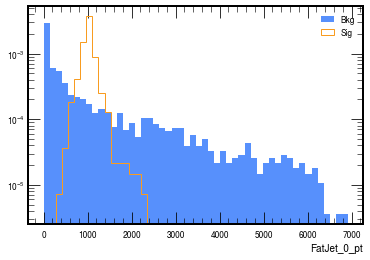

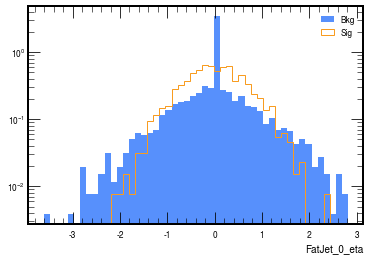

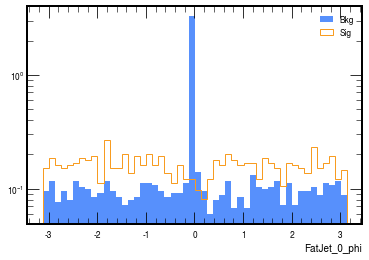

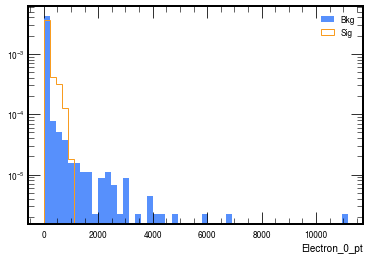

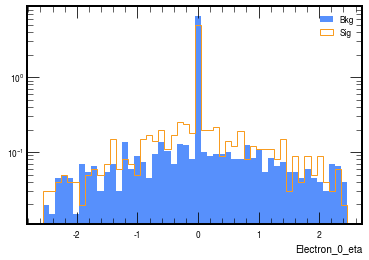

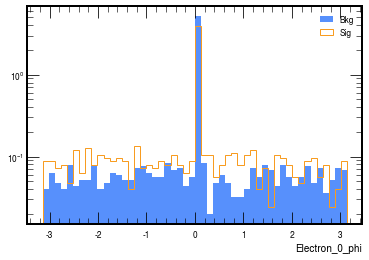

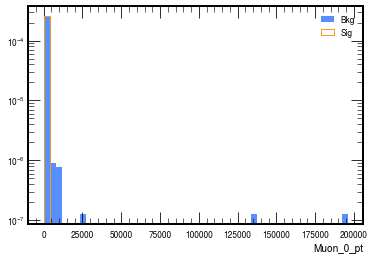

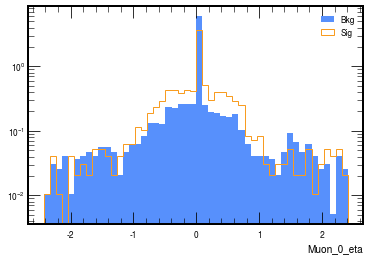

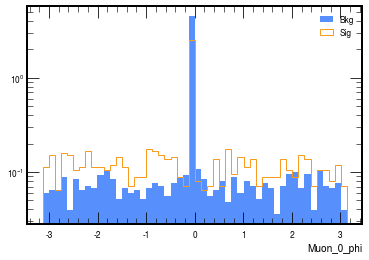

In [10]:
for i,name in enumerate(var_names[:100]):
    if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()
#     break

You can see now that for the non-sum objects we have peaks at 0 as this was the pad_val padding value for filling empty variables. 
# Final preprocessing


Let's prepare the data!
Having very different numerical ranges for the input features, as in this case where $p_T$, $\eta$ and $\phi$ have a very diffent mean, makes it difficult for the network to converge. We will therefore standardize the $p_T$.  Also, when there is no lepton present in the event, the values will be zero padded. That means there is an unnatural number of zero entries in the $p_T$. For a real use case, the loss should be rewritten as to not take zero entries into account. Ideally we would also deal with the periodicity of phi etc. Details on the best procedure for preprccesing can be found in [this paper](https://arxiv.org/abs/2108.03986). In the interest of time, we'll only do the $p_T$ scaling.

In addition, we split the training data into train/test sets and save them: 

In [11]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
_ = scaler.fit(x_bkg)
x_bkg_scaled = scaler.transform(x_bkg)
x_sig_scaled = scaler.transform(x_sig)
    
        
# define training, test and validation datasets
X_train, X_test = train_test_split(x_bkg_scaled, test_size=0.2, shuffle=True)

print("Training data shape = ",X_train.shape)    
with h5py.File('bkg_dataset.h5', 'w') as h5f:
    h5f.create_dataset('X_train', data = X_train)
    h5f.create_dataset('X_test', data = X_test)
    
with h5py.File('signal_dataset.h5', 'w') as h5f2:
    h5f2.create_dataset('Data', data = x_sig_scaled)        


Training data shape =  (1600, 42)


You  now have two new files in your reposity, `bkg_dataset.h5` and `signal_dataset.h5` which contains your train/test/val data to train the autoencoder, as well as a test data to check your performance on a New Physics signal

Let's inspect the training data:

In [12]:
with h5py.File('bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    
with h5py.File('signal_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])

 Training (#samples,#features): (1600, 42)
 Testing  (#samples,#features): (1000, 42)
Example data (1,57): [ 4.22273387e-02  2.00545702e-01 -4.84381466e-02  1.18990089e-01
 -3.85687335e-01  2.30362267e+00 -2.63363444e-01  1.18035160e-02
  2.32341652e-02 -1.27267071e-01 -1.07320168e-02  2.40603811e-02
 -4.31666654e-02 -6.22790371e-04 -4.32123292e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85186832e-01 -1.51398884e-02
 -8.82591010e-03 -6.46365796e-02 -6.71374709e-03  6.39463890e-04
 -1.25592120e-01 -2.52250245e-02 -1.15839884e-02 -4.47640390e-02
 -3.15926872e-02 -3.76272335e-02 -5.68914239e-02  3.51125583e-01
 -4.04670696e-02 -1.37156582e-01  5.27943812e-01 -3.57468232e-02
 -6.54910548e-02  3.08544081e-01 -5.31727871e-02 -3.71824654e-01
 -6.80327734e-03 -2.85562706e-02]


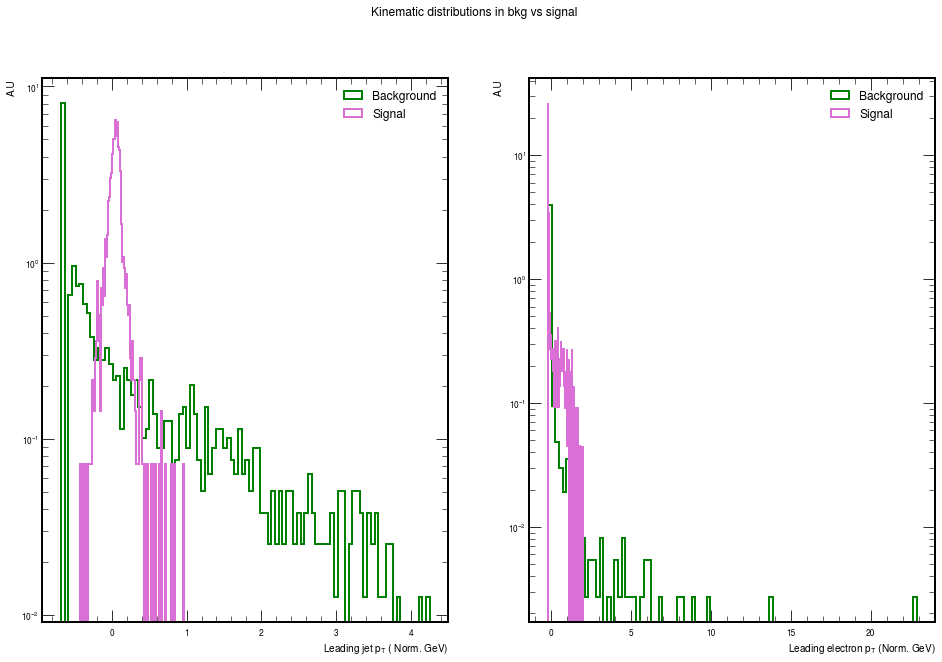

In [13]:
import matplotlib.pyplot as plt

print(" Training (#samples,#features):", X_train.shape)
print(" Testing  (#samples,#features):", signal_test_data.shape)

fig, axs = plt.subplots(1,2,figsize=(16,10))
fig.suptitle('Kinematic distributions in bkg vs signal')

axs[0].hist(X_train[:,0],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(signal_test_data[:,0 ],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading jet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_train[:,18],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(signal_test_data[:,18],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')
print("Example data (1,57):",signal_test_data[3])

# Defining the autoencoder

Now, let's define an autoencoder to learn to reconstruct the training data after compressing it through a bottleneck, then decompressing it again.

<img src="images/ae.png" alt="The autoencoder" width="800" img align="center"/>

For that, we need a stack of dense layers:

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

input_shape = X_train.shape[1]
latent_dim = 3
#encoder
inputArray = Input(shape=(input_shape,))
#x = BatchNormalization()(inputArray) #Only use this if you're not standardizing the pT
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(inputArray)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#decoder
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

2024-07-01 15:15:35.923927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 15:15:36.544086: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 15:15:36.616311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-01 15:15:36.616341: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2024-07-01 15:15:40.202573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-07-01 15:15:40.202631: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-01 15:15:40.202656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bd7dee229e6c): /proc/driver/nvidia/version does not exist
2024-07-01 15:15:40.203459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16)                0         
          

In [15]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

# Let's train!

In [ ]:
train = True #If you have a pre-trained model you can set this to false and load the other instead
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

if train:
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
              validation_split=0.2,
              callbacks=callbacks)
    # Save the model
    autoencoder.save('baseline_ae.h5')
    autoencoder.save_weights('baseline_ae.weights.h5')
    
else:
    autoencoder = tf.keras.models.load_model('baseline_ae.h5')

# Evaluating the model performance

Remember that the key metric we use for anomaly detection is the mean-squared-error: If the error is high, the data is more likely to be anomalous, and if the error is low, the data is similar to the training data (which in our case is SM events). We therefore first need to run `model.predict()` in order to get the AE reconstructed output, both for our vanilla SM test data, and for our new leptoquark signal!

In [ ]:
bkg_prediction = autoencoder.predict(X_test)
signal_prediction = autoencoder.predict(signal_test_data)

Let's see how well the network reconstructs the transverse momentum of the leptons!

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Real data versus reconsructed data')
axs[0].hist(X_test[:,0],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(bkg_prediction[:,0],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading fatjet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_test[:,18],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(bkg_prediction[:,18],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')

The reconstructed $p_T$ has an unphysical tail below zero. For a real usecase, we would force the output to be positive for that column, as well as treat the zero-padded cases differently in the loss.
To keep it short, we won't do that now, but you can read more about it [here](https://arxiv.org/abs/2108.03986)

We then need to compute the mean-square-error, which will be our final discriminating variable. This you would need to write custom if applying the changes we mention above:

In [ ]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

# compute loss value of input data versus AE reconstructed data
mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

Now, let's look at our discriminant!

In [ ]:
bin_size=100

plt.figure(figsize=(8,8))
n, bins, patches =plt.hist(mse_bsm, bins=bin_size, label="BSM", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5,range=[0,200])
n_, bins_, patches_ =plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5,range=[0,200])
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

There seems to be some discrimination power if we cut at very high values of the MSE! Let's look at a ROC curve to make it easier to vizualize

In [ ]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='BSM (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
    
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

This can obviously be further improved, but I leave that up to you :)

## Model compression
<img src="images/nmi_qkeras_hls4ml.jpeg" alt="hls4ml and qkeras" width="200" img align="left"/>

Now, there is absolutely no way anyone would let you deploy this model on an FPGA in the trigger. It will use far too many resources! Luckily, as we discussed in the lecture, there are some cheap tricks you can perform to compress the model. These are pruning and quantization-aware-training and both are very easily implemented. Let's have a look.

To quantize the model during training, such that the network will get the opportunity to adapt to the narrower bitwidth we use the library [QKeras](https://www.nature.com/articles/s42256-021-00356-5.epdf?sharing_token=A6MQVmmncHNyCtDUXzrqtNRgN0jAjWel9jnR3ZoTv0N3uekY-CrHD1aJ9BTeJNRfQ1EhZ9jJIhgZjfrQxrmxMLMZ4eGzSeru7-ASFE-Xt3NVE6yorlffwUN0muAm1auU2I6-5ug4bOLCRYvA0mp-iT-OdPsrBYeH0IHRYx0t3wc%3D), developed in a joint effort between CERN and Google.

# Quantization aware training with QKeras

Quantization is a powerful way to reduce model memory and resource consumption. In this tutorial, we will use the libary QKeras to perform quantization aware training (QAT).

In contrast to in Keras, where models are trained using floating point precision, QKeras quantizes each of the model weights and activation functions during training, allowing the network to adapt to the numerical precision that will eventually be used on hardware.

During the forward pass of the network, each floating point weight is put into one of $2^{bitwidth}$ buckets. Which one it goes into is defined through rounding and clipping schemes.

Below you can see an example of a tensor with a (symmetric) dynamic range of $x_{f}$ $[-amax, amax]$ mapped through quantization to a an 8 bit integer, $2^8=256$ discrete values in the interval $[-128, 127]$ (32-bit floating-point can represent ~4B numbers in the interval $[-3.4e38, 3.40e38]$).

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/8-bit-signed-integer-quantization.png?ref_type=heads" width="800"/>

Quantization of floating point numbers can be achieved using the quantization operation

$$x_{q} = Clip(Round(x_{f}/scale))$$

where $x_{q}$ is the quantized digit and $x_{f}$ is the floating point digit. $Round$ is a function that applies some rounding scheme to each number and $Clip$ is a function that clips outliers that fall outside the $[-128, 127]$ interval. The $scale$ parameter is obtained by dividing the float-point dynamic-range into 256 equal parts.

On FPGA, we do not use int8 quantization, but fixed-point quantization, bu the idea is similar. Fixed-point representation is a way to express fractions with integers and offers more control over precision and range. We can split the $W$-bits making up an integer (in our case $W=8$) to represent the integer part of a number and the fractional part of the number. We usually reserve 1-bit representing the sign of the digit. The radix splits the remaining $W-1$ bits to $I$ most significant bits representing the integer value and $F$ least significant bits representing the fraction. We write this as $<W,I>$, where $F=W-1-I$.  Here is an example for an unsigned $<8,3>$:

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/fixedpoint.png?ref_type=heads" width="400"/>


This fixed point number corresponds to $2^4\cdot0+2^3\cdot0+2^2\cdot0+2^1\cdot1+2^0\cdot0+2^{-1}\cdot1+2^{-2}\cdot1+2^{-3}\cdot0=2.75$.

The choice of $I$ and $F$ has to be derived as a trade-off between representation range and precision, where $I$ controls the range and $F$ the precision.

In the following we will use a bitwidth of 8 and 0 integer bits. Not considering the sign bit, this means that the smallest number you can represent (the precision) and the largest number (the range) is:

$$ \rm{Precision}= \frac{1}{2^{F}}= \frac{1}{2^8} = 0.00390625$$
$$\rm{Range}= [-2^0,-2^0-1]=[-1,0] $$
With zero integer bits the largest number you can represent is just below (but not including) 1. For weights in deep neural networks, being constrained to be less than 1 is often a reasonable assumtion.



What QKeras (and other QAT libraries) do, is to include the quantization error during the training, in the following way:
- "Fake quantize" the floating-point weights and activations during the forward pass: quantize the weights and use them for the layer operations
- Immediately un-quantize the parameters so the rest of the computations take place in floating-point
- During the backward pass, the gradient of the weights is used to update the floating point weight
- The quantization operation gradient (zero or undefined) is handled by passing the gradient through as is ("straight through estimator")


## Translating to a QKeras QAT model
There are two ways to translate this into a QKeras model that can be trained quantization aware, lets first do it manually:

### Manual QKeras model definition:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

input_shape = X_train.shape[1]
latent_dim = 3

#encoder
inputArray = Input(shape=(input_shape,))
# x = BatchNormalization()(inputArray)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(inputArray)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
encoder = QDense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)', name='bottleneck')(x)

#decoder
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(encoder)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
decoder = QDense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)')(x)

#create autoencoder
q_autoencoder = Model(inputs = inputArray, outputs=decoder)
q_autoencoder.summary()

Wait! What is going on here?
The magic happens in ```quantized_bits``` (see implementation [here](https://github.com/google/qkeras/blob/master/qkeras/quantizers.py#L1245)), where the parameters are the following:
- ```bits```: The bitwidth, allowing you to have $2^{bits}$ unique values of each weight parameter
- ```integers```: How many are integer bits, in this case zero. All 8 bits are used to represent the fractional part of the weight parameter, with no bits dedicated to representing whole numbers. This forces the value to be between -1 and 1. For DNNs this can be useful because the focus is entirely on the precision of the fraction rather than the magnitude of the number. Question: Would this also work on the output node if your algorithm is a regression of the jet mass?
- ```symmetric```: should the values be symmetric around 0? In this case it doesnt have to be.
- ```alpha```: with $2^W$ unique values available, we could let them go from $[-2^W, 2^W-1]$ like above, but we can also let them go from $[-2^W*\alpha, (2^W-1)*\alpha]$. ```alpha``` is a scaling of the weights. Enabling this often leads to improved performance, but it doesnt talk so nicely to hls4ml, so we recommend leaving it at 1 (or get ready for having to debug)

Having added this, QKeras will automatically apply fake quantization for us during the forward pass, accounting for the quantization error and returning a network that is optimized for the precision you plan on using in hardware.

Another thing to notice is that we leave the sigmoid and the final output logit unquantized. This is because this is were we want the values to be very accurate, and it is not going to save us a lot of resources quantizing it.


### Automatic model quantization through config
 You can also set the quantization for the full model using a model configuration. Sometimes this can be sater if you're using the same quantizer for all layers of the same type. You don't have to use this for this tutorial, we already have a model, but we will leave it here as an example:

In [ ]:
autoQuant = False

if autoQuant:
    config = {
      "QDense": {
          "kernel_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
          "bias_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
      },
      "QActivation": { "relu": "quantized_relu(8)" }
    }
    from qkeras.utils import model_quantize

    qmodel = model_quantize(autoencoder, config, 4, transfer_weights=True)

    for layer in qmodel.layers:
        if hasattr(layer, "kernel_quantizer"):
            print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
        elif hasattr(layer, "quantizer"):
            print(layer.name, "quantizer:", str(layer.quantizer))

    print()
    qmodel.summary()

But be careful that activation functions like softmax/sigmoid and perhaps logit layers you want to keep at full presision doesn't get quantized!

## But how many bits?

So now we know how to quantize our models, but how do we know wich precision to choose?
Finding the best number of bits and integer bits to use is non-trivial, and there are two ways we recommend:
- The easiest strategy is to scan over the possible bit widths from binary up to some maximum value and choose the smallest one that still has acceptable accuracy, and this is what we often do. 
Code for how to do this can be found [here](https://github.com/thesps/keras-training/blob/qkeras/train/train_scan_models.py#L16), and is illustrated below.
For binary and ternary quantization, we use the special ```binary(alpha=1.0)(x)``` and ```ternary(alpha=1.0)(x)``` quantizers. 

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/quant_scan.png?ref_type=heads" width="400"/>

- Another thing you can do is to use our library for automatic quantization, [AutoQKeras](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb), to find the optimal quantization for each layer. This runs hyperparameter optimisation over quantizers/nodes/filters simultenously. An example can be found at the end of [this notebook](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part6_cnns.ipynb) "Bonus exercise: Automatic quantization with AutoQKeras".

## Pruning

Besides reducing the numerical precision of all the weights, biases and activations, I also want to remove neurons and synapses that do not contribute much to the network overall decision. We do that by pruning, let's remove 50\% of the weights (spasity=0.5):
Let's make sure to skip our latent dimension!

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': pruning_schedule.PolynomialDecay(initial_sparsity=0.05,final_sparsity=0.50, begin_step=0, end_step=100, frequency=100)}
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='bottleneck':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

# q_autoencoder.load_weights('baseline_ae.weights.h5')
qp_autoencoder = tf.keras.models.clone_model( q_autoencoder, clone_function=pruneFunction)
qp_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

In [ ]:
train = True
EPOCHS = 150
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=False))
callbacks.append(pruning_callbacks.UpdatePruningStep())
if train:
        
    history = qp_autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_split=0.2,
                  callbacks=callbacks)
    # Save the model
    qp_autoencoder = strip_pruning(qp_autoencoder)
    qp_autoencoder.save('qkeras_ae.h5')
    
else:
    from qkeras.utils import _add_supported_quantized_objects
    co = {}; _add_supported_quantized_objects(co)

    qp_autoencoder = tf.keras.models.load_model('qkeras_ae.h5',custom_objects=co)
    

Let's quickly check that the pruning worked and 50% of the weights are indeed 0!

In [ ]:
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(autoencoder) 
doWeights(qp_autoencoder) 

Indeed, a huge spike at zero for the pruned model! Let's compare the performance to the floating point precision, unpruned model:

In [ ]:
bkg_prediction = qp_autoencoder.predict(X_test)
signal_prediction = qp_autoencoder.predict(signal_test_data)

# compute loss value of input data versus AE reconstructed data
q_mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
q_mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

target_background = np.zeros(q_mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(q_mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((q_mse_bsm, q_mse_sm))

q_fpr_loss, q_tpr_loss, q_threshold_loss = roc_curve(trueVal, predVal_loss)

q_auc_loss = auc(q_fpr_loss, q_tpr_loss)

In [ ]:
plt.figure(figsize=(8,8))
    
plt.plot(fpr_loss, tpr_loss, "-", label='Baseline (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
plt.plot(q_fpr_loss, q_tpr_loss, "-", label='Quantized+Pruned (auc = %.1f%%)'%(q_auc_loss*100.), linewidth=1.5, color = "green")

plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.ylim(0.001,1)
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='orange', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

Take a moment to appreciate what an absolutely fantastic result this is! We can reduce the numerical precision of the model from floating point 32 representation to 8-bit fixed point precision, remove 50% of the weights *and still get the same performance*!! This is a crucial, and absolutely neccessary, part of making deep neural networks in particle detector data aquisition systems a reality (also, note that AUC is not a good metric for trigger applications, where you typically operate at very low false positive rates of 10E-5).

So it seems despite having reduced the numerical precision of the model and the input, as well as removing 50% of the model weights, we're doing pretty good! This can be tuned to get even better, by carefully adjusting the input precision and the model precision, especially increaseing the precision of the logit layer.

# Generating firmware with

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/hls4ml_logo.png?ref_type=heads" width="400"/>

Time to translate this model into HLS (which we will integrate in the emulator) and use to generate the vhdl to be integrated in the trigger firmware. We will use the Python library hls4ml for that ([here](https://github.com/fastmachinelearning/hls4ml-tutorial/tree/main) is the hls4ml tutorial).
hls4ml seamlessly talks to QKeras, making our jobs way easier for us, but there is still some work for us to do to make sure we get good hardware model accuracy. Lets start!
There are a few things I already know in advance and would like my model to include:
- Be execuded fully parallel (=unrolled) to reach the lowest possible latency. We set the ReuseFactor=1 and Strategy=Latency
- The correct input precision
- The correct model output (that's something you have to figure out yourself!)
- Use "correct" precisions to make sure the hardware model performs the same as the software one. QKeras handles weights/biases and activation functions for us, but there are a few other parameters that need to be set by hand

For the final point, have a look at the following diagram:

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/hls4ml_precisions.png?ref_type=heads" width="400"/>

Whereas the $weight$ and $bias$ is set to its optimal value from the QKeras model, the accumulator $accum$ and $result$ is set to some default value that might not be optimal for a given model and might need tuning. Let's do a first attemt:

In [ ]:
import hls4ml

def print_dict(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent + 1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))
            

config = hls4ml.utils.config_from_keras_model(qp_autoencoder, granularity='name')
config["Model"]["Strategy"] = "Latency"
config["Model"]["ReuseFactor"] = 1

inputPrecision = "ap_fixed<16,7,AP_RND,AP_SAT>" #The input also will be quantized! quantized_bits(16,6) becomes "ap_fixed<16,7>. Adding one bit for the sign, different definitions QKeras/Vivado
for layer in qp_autoencoder.layers:
    if layer.__class__.__name__ in ["InputLayer"]:
        config["LayerName"][layer.name]["Precision"] = inputPrecision
config["LayerName"]["q_dense_4"]["Precision"]["result"] = "ap_fixed<16,7,AP_RND,AP_SAT>"       

# If the logit layer is a "normal" Keras kayer and has not been quantized during the training, 
# we need to be careful setting the accuracy. This can be done in the following way:
# config["LayerName"]["logits"]["Precision"]["weight"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["bias"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["accum"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["result"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 

print("-----------------------------------")
print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(qp_autoencoder, 
                                                       hls_config=config, 
                                                       io_type='io_parallel', #other option is io_stream
                                                       output_dir='L1TMLDemo_v1',
                                                       project_name='L1TMLDemo_v1', 
                                                       part='xcu250-figd2104-2L-e', #Target FPGA, ideally you would use VU9P and VU13P that we use in L1T but they are not installed at lxplus, this one is close enought for this
                                                       clock_period=2.5, # Target frequency 1/2.5ns = 400 MHz
#                                                        input_data_tb='qX_test.npy', # For co-simulation
#                                                        output_data_tb='qy_test.npy',# For co-simulation
)
hls_model.compile()

First, what does our newly created model look like?

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Here you can see that the precision is what we set it to be in QKeras as well as what we set manually in the config. One thing to note is the different definitions used in QKeras and in ap_fixed:
- ```quantized_bits(8,0) -> ap_fixed<8,1>```
- ```quantized_relu(8,0) -> ap_ufixed<8,0>```
Also you can see that the defualt value for result/accu is set to $16,6$. This can also be tuned to more optimal values.

## Validate the firmware model accuracy

#et's also run predict on the C++ implementation of our model and make sure it's the ~same as for the QKeras model.
This is very slow for the C++ implementation of our model, but we need a lot of statistics to probe the low rate region.

### <span style="color:green">Execute the next cell, then grab a quick coffee while its running (<5 minutes)</span>


In [ ]:
hls_bkg_prediction = hls_model.predict(np.ascontiguousarray(X_test))
hls_signal_prediction = hls_model.predict(np.ascontiguousarray(signal_test_data))

# compute loss value of input data versus AE reconstructed data
hls_mse_sm = mse_loss(X_test, hls_bkg_prediction.astype(np.float32)).numpy()
hls_mse_bsm = mse_loss(signal_test_data,hls_signal_prediction.astype(np.float32)).numpy()

target_background = np.zeros(hls_mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(hls_mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((hls_mse_bsm, hls_mse_sm))

hls_fpr_loss, hls_tpr_loss, hls_threshold_loss = roc_curve(trueVal, predVal_loss)

hls_auc_loss = auc(hls_fpr_loss, hls_tpr_loss)

In [ ]:
# Let's print and compare some of the predictions:
print(f"Truth input:\n {X_test[0]}\n")
print(f"Qkeras reconstruction:\n {bkg_prediction[0]}\n")
print(f"HLS reconstruction:\n {hls_bkg_prediction[0]}\n")

In [ ]:
# Lets plot it!
plt.figure()
    
plt.plot(fpr_loss, tpr_loss, "-", label='Baseline (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
plt.plot(q_fpr_loss, q_tpr_loss, "-", label='Quantized+Pruned (auc = %.1f%%)'%(q_auc_loss*100.), linewidth=1.5, color = "green")
plt.plot(hls_fpr_loss, hls_tpr_loss, "--", label='HLS (auc = %.1f%%)'%(hls_auc_loss*100.), linewidth=1.5, color = "red")

plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.ylim(0.001,1)
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.show()

Oh! That was easier than expected. If you see the accuracies differing significantly, it's a good idea to look into accumulator and reult precisions. Also with tools like $Trace$ and $Profiling$ that you can learn from in the [official hls4ml tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part2_advanced_config.ipynb) can be helpful! In this case, it doesnt seem like it's necessary. 

## Synthesise!

Now let's build it! Lets run C-synthesis (C++ to register-transfer level) and Vivado logic synthesis (gate level representation). We will not do co-simulation (send test vectors, do an exhaustive functional test of the implemented logic), but this can be a good idea if you are using CNNs and the $io_stream$ io. 

Let's run!

### <span style="color:green">Sadly we won't get any further for this tutorial. Idid not manage to include a Vitis licenses and software for this tutorial. But you can work through the [hls4ml tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial/tree/main), where there is a container with Vivado available!</span>

# Exercises
1. This is not such a great anomaly detection algorithm. Can you improve it? I would start adding by adding other input features
2. Making an event-level anomaly detection algorithm is useful to be sensitive to many different BSM final states. In this exercise, see if you can rather make an anomalous jet detection algorithm (hint: you have access to other features of the FatJet than the four-momentum!)
3. Make your own algorithm using the tools you have learnt here!

Hint, if you want to include MET or HT they won't become "objects" like the electron/muon/jets. You could also not "zip" when loading, and then do the zip'ing manually:
```
# Lets convert to correct formatting ao that all objects are zipped together as Momentum4D vectors
new_arr_sig = {}
for obj, brs in branch_dict.items():
    new_arr_sig[obj] = ak.zip({ br : data_sig[obj + "_" + br] for br in brs} )
      
  
# making sure it is a Momentum4D object like the rest
final_arr_sig = {}
for key, value in new_arr_sig.items(): final_arr_sig[key] = ak.Array( value, with_name = "Momentum4D" )

len(ak.Array(final_arr_sig))

new_arr_bkg = {}
for obj, brs in branch_dict.items():
    new_arr_bkg[obj] = ak.zip({ br : data_bkg[obj + "_" + br] for br in brs} )
      
  
# making sure it is a Momentum4D object like the rest
final_arr_bkg = {}
for key, value in new_arr_bkg.items(): final_arr_bkg[key] = ak.Array( value, with_name = "Momentum4D" )

len(ak.Array(final_arr_sig))

data_sig = ak.Array(final_arr_sig)
data_bkg = ak.Array(final_arr_bkg)
